<a href="https://colab.research.google.com/github/amir-asari/CLIP-Basic/blob/main/CLIP_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import necessary libraries

In [4]:
import torch
from torchvision.datasets import CIFAR10
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import matplotlib.pyplot as plt

### ==============================================================================
### STEP 1: Load Model, Processor, and Dataset
### ==============================================================================
This step loads the pre-trained model, its processor, and the dataset.
This is the most time-consuming part and should only be run once.

In [5]:
# Check if a GPU is available and set the device accordingly
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# --- Load Model and Processor ---
# Load the pre-trained CLIP model and its processor from Hugging Face
print("Loading CLIP model and processor...")
try:
    model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
    processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
    print("CLIP model and processor loaded successfully.")
except Exception as e:
    print(f"Error loading model or processor: {e}")
    model = None # Set to None on failure

# --- Load Dataset ---
# Download and load the CIFAR-10 training dataset
print("\nLoading CIFAR-10 dataset...")
try:
    dataset = CIFAR10(root="./data", train=True, download=True)
    print("CIFAR-10 dataset loaded successfully.")
except Exception as e:
    print(f"Error loading CIFAR-10 dataset: {e}")
    dataset = None # Set to None on failure

Using device: cuda
Loading CLIP model and processor...
CLIP model and processor loaded successfully.

Loading CIFAR-10 dataset...
CIFAR-10 dataset loaded successfully.


### ==============================================================================
### STEP 2: Define the Classification Function
### ==============================================================================
This function now takes the model, processor, and dataset as arguments,
making it much faster to call multiple times.

In [6]:
def classify_cifar_image(model, processor, dataset, image_index=0):
    """
    Uses a pre-loaded CLIP model to classify a CIFAR-10 image.

    Args:
        model (CLIPModel): The pre-loaded CLIP model.
        processor (CLIPProcessor): The pre-loaded CLIP processor.
        dataset (Dataset): The pre-loaded CIFAR-10 dataset.
        image_index (int): The index of the image to classify.
    """
    if not all([model, processor, dataset]):
        print("Model, processor, or dataset not loaded. Cannot proceed.")
        return

    # --- 1. Get Image and Labels ---
    image, label_id = dataset[image_index]
    class_names = dataset.classes
    print(f"\n--- Classifying Image at Index: {image_index} ---")
    print(f"Actual label: {class_names[label_id]}")

    # --- 2. Prepare Inputs ---
    text_prompts = [f"a photo of a {class_name}" for class_name in class_names]
    inputs = processor(
        text=text_prompts,
        images=image,
        return_tensors="pt",
        padding=True
    ).to(device)

    # --- 3. Perform Inference ---
    with torch.no_grad():
        outputs = model(**inputs)
        logits_per_image = outputs.logits_per_image
        probs = logits_per_image.softmax(dim=1)
    print("Inference complete.")

    # --- 4. Display Results ---
    probs_list = probs.cpu().numpy().flatten().tolist()
    results = {class_names[i]: probs_list[i] for i in range(len(class_names))}
    predicted_label = max(results, key=results.get)

    print(f"Predicted Label: {predicted_label} (Probability: {results[predicted_label]:.4f})")

    # Display the image with its actual and predicted labels
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.title(f"Actual: {class_names[label_id]}\nPredicted: {predicted_label}", fontsize=14)
    plt.axis("off")
    plt.show()

### ==============================================================================
### STEP 3: Run Classification
### ==============================================================================
This is the execution step.
You can easily change the image_index and re-run only this step
to test different images quickly.



--- Classifying Image at Index: 15 ---
Actual label: truck
Inference complete.
Predicted Label: truck (Probability: 0.9909)


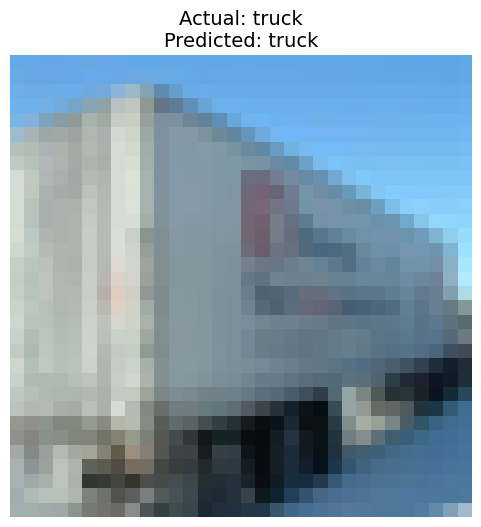

In [7]:
# Set the index for the image you want to classify.
image_to_classify_index = 15

# Call the function to perform the classification.
classify_cifar_image(model, processor, dataset, image_index=image_to_classify_index)

### ==============================================================================
### STEP 4: Example with another image
### ==============================================================================
Classifying another image is now fast, as we just call the function again.


--- Classifying Image at Index: 1234 ---
Actual label: airplane
Inference complete.
Predicted Label: airplane (Probability: 0.8535)


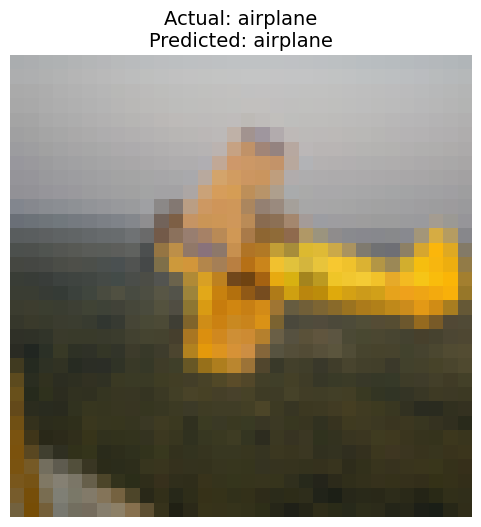

In [9]:
classify_cifar_image(model, processor, dataset, image_index=1234)